
=== 1. 分詞結果 (已去除停用詞) ===
句子 0: ['我', '特別', '特別', '喜歡', '看', '電影']
句子 1: ['電影', '真的', '好看', '電影']
句子 2: ['今天', '天氣', '好', '難', '得', '好', '天氣']
句子 3: ['我', '今天', '看', '電影']
句子 4: ['電', '影院', '電影', '好看']

=== 2. 詞袋模型矩陣 (BoW Matrix) ===


,我,特別,喜歡,看,電影,真的,好看,今天,天氣,好,難,得,電,影院
句子_0,1,2,1,1,1,0,0,0,0,0,0,0,0,0
句子_1,0,0,0,0,2,1,1,0,0,0,0,0,0,0
句子_2,0,0,0,0,0,0,0,1,2,2,1,1,0,0
句子_3,1,0,0,1,1,0,0,1,0,0,0,0,0,0
句子_4,0,0,0,0,1,0,1,0,0,0,0,0,1,1


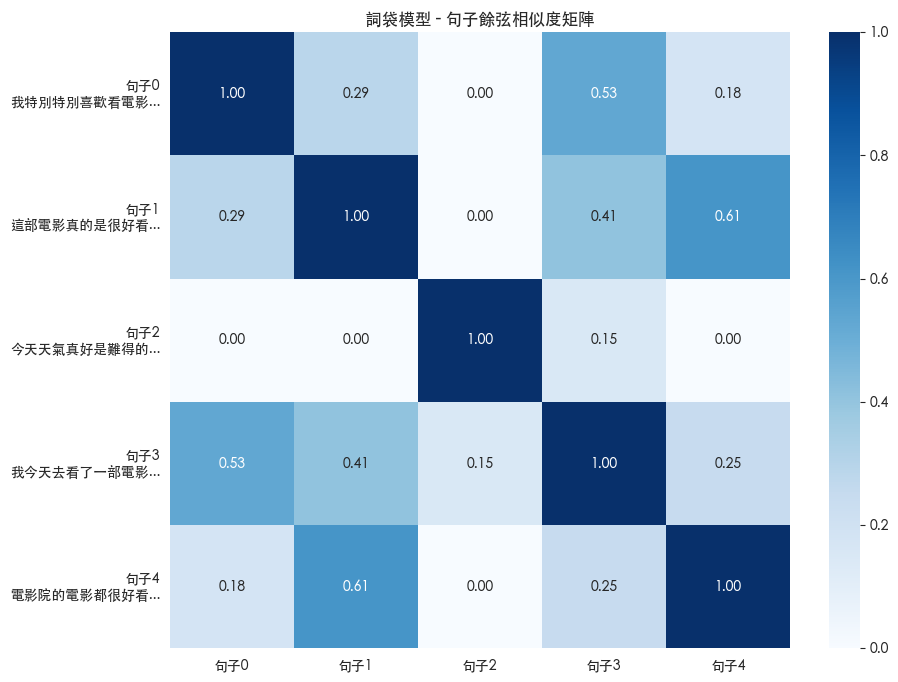

In [9]:
import warnings

# 過濾 jieba 在 Python 3.12+ 的 SyntaxWarning（jieba 套件已久未更新）
warnings.filterwarnings("ignore", category=SyntaxWarning, module="jieba")
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")

import jieba
import numpy as np
import pandas as pd
import platform
import matplotlib.pyplot as plt
import seaborn as sns  # 使用 seaborn 讓圖表更美觀

# ==========================================
# 1. 設置配置與數據
# ==========================================
# 設置中文字體 (避免繪圖亂碼)
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang HK', 'Arial Unicode MS']
else:  # Windows / Linux
    plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

corpus = [
    "我特別特別喜歡看電影",
    "這部電影真的是很好看的電影",
    "今天天氣真好是難得的好天氣",
    "我今天去看了一部電影",
    "電影院的電影都很好看"
]

# 定義停用詞 (Stop Words)：這些詞對判斷相似度貢獻很低，建議過濾
stop_words = {'的', '是', '了', '真', '很', '去', '都', '一部', '這部'}


# ==========================================
# 2. 核心邏輯封裝
# ==========================================

def get_vocab_and_vectors(corpus, stop_words):
    """
    輸入語料庫，返回：
    1. 分詞後的列表
    2. 詞彙表 (Vocabulary)
    3. 詞袋向量 (BoW Vectors)
    """
    tokenized_sentences = []

    # --- 分詞與過濾停用詞 ---
    for sentence in corpus:
        words = jieba.cut(sentence)
        # 過濾掉 停用詞 和 空白字符
        filtered_words = [w for w in words if w not in stop_words and w.strip()]
        tokenized_sentences.append(filtered_words)

    # --- 建立詞彙表 (保持順序) ---
    vocabulary = []
    for words in tokenized_sentences:
        for w in words:
            if w not in vocabulary:
                vocabulary.append(w)

    # --- 建立詞袋向量 ---
    bow_vectors = []
    for words in tokenized_sentences:
        # 初始化全 0 向量
        vec = [0] * len(vocabulary)
        for w in words:
            if w in vocabulary:
                index = vocabulary.index(w)
                vec[index] += 1
        bow_vectors.append(vec)

    return tokenized_sentences, vocabulary, np.array(bow_vectors)


def cosine_similarity(vec1, vec2):
    """計算餘弦相似度"""
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return dot_product / (norm_a * norm_b)


# ==========================================
# 3. 執行與展示
# ==========================================

# 執行處理
tokens, vocab, vectors = get_vocab_and_vectors(corpus, stop_words)

# --- 1: 使用 Pandas 顯示詞頻矩陣 ---
# 這一步最能體現 BoW 的物理意義：每一列代表一個詞，每一行代表一個句子
df_bow = pd.DataFrame(vectors, columns=vocab, index=[f"句子_{i}" for i in range(len(corpus))])

print("\n=== 1. 分詞結果 (已去除停用詞) ===")
for i, t in enumerate(tokens):
    print(f"句子 {i}: {t}")

print("\n=== 2. 詞袋模型矩陣 (BoW Matrix) ===")
# 高亮顯示非 0 的值，讓稀疏矩陣更直觀
display(df_bow.style.background_gradient(cmap='Blues', axis=None, low=0, high=1.0))

# --- 計算相似度矩陣 ---
sim_matrix = np.zeros((len(corpus), len(corpus)))
for i in range(len(corpus)):
    for j in range(len(corpus)):
        sim_matrix[i][j] = cosine_similarity(vectors[i], vectors[j])

# ==========================================
# 4. 可視化優化
# ==========================================
plt.figure(figsize=(10, 8))
# 使用 seaborn 的 heatmap，自帶數值標註(annot=True)，比 matshow 更易讀
sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=[f"句子{i}" for i in range(len(corpus))],
            yticklabels=[f"句子{i}\n" + corpus[i][:10] + "..." for i in range(len(corpus))])  # Y軸加上部分原文方便對照

plt.title("詞袋模型 - 句子餘弦相似度矩陣")
plt.show()